In [7]:
# librerias
import numpy as np
import pandas as pd

import statsmodels.api as sm
from scipy import stats

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [4]:
# funciones
def to_returns(prices: pd.DataFrame, method="log"):
    """Convierte precios a retornos diarios."""
    if method == "log":
        return np.log(prices).diff().dropna()
    else:
        return prices.pct_change().dropna()

def annualize_mean(r, periods_per_year=252):
    return r.mean() * periods_per_year

def annualize_vol(r, periods_per_year=252):
    return r.std() * np.sqrt(periods_per_year)

def sharpe_ratio(r, rf=0.0, periods_per_year=252):
    # rf en misma frecuencia que r (si rf anual, conviértelo antes)
    excess = r - rf
    return annualize_mean(excess, periods_per_year) / annualize_vol(r, periods_per_year)

## El mercado NO paga por riesgo diversificable

Vamos a crear un “mundo” con 3 activos correlacionados y ver qué le pasa al riesgo al diversificar.

In [6]:
np.random.seed(7)

n = 1500  # ~6 años de días hábiles
mu = np.array([0.0004, 0.00035, 0.0003])  # medias diarias
cov = np.array([
    [0.00018, 0.00012, 0.00010],
    [0.00012, 0.00020, 0.00011],
    [0.00010, 0.00011, 0.00016]
])

R = np.random.multivariate_normal(mu, cov, size=n)
rets = pd.DataFrame(R, columns=["A", "B", "C"])

print(rets.head(3))
print()
weights = np.array([1/3, 1/3, 1/3])
port = rets @ weights

print("Vol anual A:", annualize_vol(rets["A"]))
print("Vol anual B:", annualize_vol(rets["B"]))
print("Vol anual C:", annualize_vol(rets["C"]))
print("Vol anual Port(1/3):", annualize_vol(port))

          A         B         C
0 -0.022283 -0.019514 -0.015653
1 -0.009692 -0.002095 -0.001271
2 -0.011220  0.000786  0.012586

Vol anual A: 0.20770859717207266
Vol anual B: 0.22226760969368578
Vol anual C: 0.20239937484025922
Vol anual Port(1/3): 0.18135660265668663


# 2 Markowitz frontera eficiente

In [9]:
# import numpy as np
# A = np.array([[1, 2], [3, 4]])
# B = np.array([[5, 6], [7, 8]])
# print("Matriz A:\n", A)
# print("Matriz B:\n", B)

# # Producto matricial (A * B)
# resultado = np.einsum('ij,jk->ik', A, B)
# # Resultado: [[19, 22], [43, 50]]
# print("Producto matricial A * B:\n", resultado)

In [3]:
# import numpy as np

# # Define concentration parameters (e.g., 3 categories)
# alpha = [10, 5, 1] 

# # Generate a single sample (a vector of 3 probabilities summing to 1)
# sample = np.random.dirichlet(alpha)
# print("Single Sample:", sample)
# print("Sum:", np.sum(sample))

# # Generate 5 samples
# samples = np.random.dirichlet(alpha, size=5)
# for i, s in enumerate(samples):
#     print(f"Sample {i+1}: {s}, Sum: {np.sum(s)}")
# print("\n5 Samples:\n", samples)


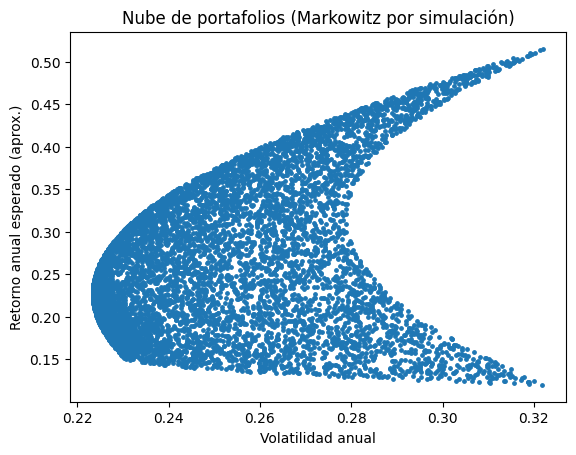

In [ ]:
def random_weights(k, n_portfolios=5000):
    W = np.random.dirichlet(np.ones(k), size=n_portfolios)
    return W

def portfolio_stats(rets: pd.DataFrame, W: np.ndarray, periods_per_year=252):
    mu = rets.mean().values
    Sigma = rets.cov().values
    port_mu = W @ mu
    port_var = np.einsum('ij,jk,ik->i', W, Sigma, W)
    port_vol = np.sqrt(port_var)
    return (port_mu * periods_per_year, port_vol * np.sqrt(periods_per_year))

W = random_weights(3, n_portfolios=8000)
mu_a, vol_a = portfolio_stats(rets, W)

plt.figure()
plt.scatter(vol_a, mu_a, s=6)
plt.xlabel("Volatilidad anual")
plt.ylabel("Retorno anual esperado (aprox.)")
plt.title("Portafolios (Markowitz por simulación)")
plt.show()

# 3 CAPM: beta, alpha y la trampa clásica

## 3.1 Simulamos un mercado y un activo

In [ ]:
np.random.seed(12)

n = 1800
mkt = np.random.normal(0.00035, 0.011, size=n)  # retorno mercado diario
rf = 0.00008  # tasa libre riesgo diaria

true_beta = 1.3
true_alpha = 0.00002  # muy pequeño
eps = np.random.normal(0, 0.014, size=n)

asset = true_alpha + true_beta * (mkt - rf) + eps

df = pd.DataFrame({
    "MKT": mkt,
    "RF": rf,
    "ASSET": asset
})

df["MKT_EXCESS"] = df["MKT"] - df["RF"]
df["ASSET_EXCESS"] = df["ASSET"] - df["RF"]
df.head()

,MKT,RF,ASSET,MKT_EXCESS,ASSET_EXCESS
0,0.005553,0.00008,0.034547,0.005473,0.034467
1,-0.007146,0.00008,-0.038604,-0.007226,-0.038684
2,0.003017,0.00008,-0.006279,0.002937,-0.006359
3,-0.018358,0.00008,-0.042133,-0.018438,-0.042213
4,0.008635,0.00008,0.001305,0.008555,0.001225


## 3.2 Estimación CAPM (OLS)

In [11]:
X = sm.add_constant(df["MKT_EXCESS"])
y = df["ASSET_EXCESS"]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           ASSET_EXCESS   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     1780.
Date:                Sat, 24 Jan 2026   Prob (F-statistic):          5.51e-271
Time:                        15:56:33   Log-Likelihood:                 5164.0
No. Observations:                1800   AIC:                        -1.032e+04
Df Residuals:                    1798   BIC:                        -1.031e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.000     -0.562      0.5

Interpretación guiada (lo importante):

* $\beta$ (beta): sensibilidad al mercado.
* $\alpha$ (alpha): “retorno extra” no explicado por mercado (a veces suerte disfrazada).
* $Rˆ2$: qué tanto explica el mercado el activo.

## 3.3 El test de “¿alpha real o humo?”

Alpha pequeño + p-value alto = probablemente nada.

In [12]:
alpha = model.params["const"]
beta = model.params["MKT_EXCESS"]
p_alpha = model.pvalues["const"]

print("alpha diaria:", alpha)
print("beta:", beta)
print("p-value alpha:", p_alpha)

alpha diaria: -0.0001821115282244326
beta: 1.2418207397303818
p-value alpha: 0.5740397574807068


## 3.4 SML (línea de mercado de valores) en versión práctica

CAPM en expectativas:

$$ E[R_i] = R_f + \beta_i(E[R_m]-R_f) $$

In [13]:
# estimamos primas anuales con nuesrtras medias muestrales
Erm = annualize_mean(df["MKT"])
Erf = annualize_mean(df["RF"])
capm_return = Erf + beta * (Erm - Erf)

print("E[Rm] anual:", Erm)
print("Rf anual:", Erf)
print("E[Ri] CAPM anual:", capm_return)
print("E[Ri] muestral anual:", annualize_mean(df["ASSET"]))

E[Rm] anual: -0.0031995449082991745
Rf anual: 0.02016
E[Ri] CAPM anual: -0.008848367337789154
E[Ri] muestral anual: -0.05474047245034627


	• Si el CAPM “no cuadra” no significa que no sirva el modelo.
	• Significa que revises: ventana temporal, estabilidad, regime change, datos, etc.

# Data Real

In [12]:
import yfinance as yf

tickers = ["AAPL", "MSFT", "GOOGL"]
data = yf.download(tickers, start="2025-01-01", end="2025-12-31", progress=False)["Close"]
rets = to_returns(data)
print(rets.head(3))

weights = np.array([1/3, 1/3, 1/3])
port = rets @ weights
print()
print(f"Vol anual {tickers[0]}:", annualize_vol(rets[tickers[0]]))
print(f"Vol anual {tickers[1]}:", annualize_vol(rets[tickers[1]]))
print(f"Vol anual {tickers[2]}:", annualize_vol(rets[tickers[2]]))
print(f"Vol anual Port(1/3):", annualize_vol(port))

Ticker          AAPL     GOOGL      MSFT
Date                                    
2025-01-03 -0.002012  0.012381  0.011331
2025-01-06  0.006716  0.026143  0.010573
2025-01-07 -0.011453 -0.007034 -0.012891

Vol anual AAPL: 0.3222453346315632
Vol anual MSFT: 0.24103681617029118
Vol anual GOOGL: 0.3233684786617778
Vol anual Port(1/3): 0.2377730820176319


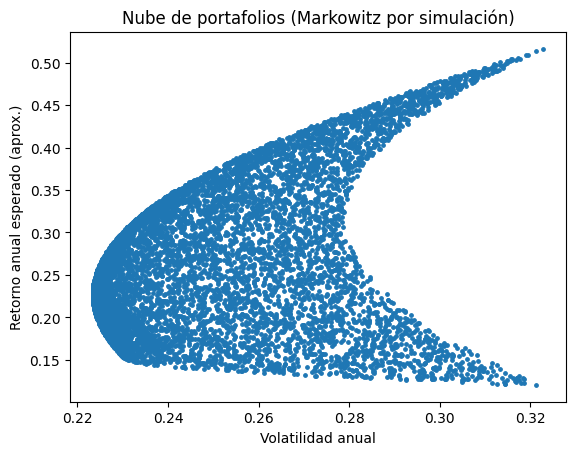

In [15]:
W = random_weights(3, n_portfolios=8000)
mu_a, vol_a = portfolio_stats(rets, W)

plt.figure()
plt.scatter(vol_a, mu_a, s=6)
plt.xlabel("Volatilidad anual")
plt.ylabel("Retorno anual esperado (aprox.)")
plt.title("Portafolios (Markowitz por simulación)")
plt.show()

In [16]:
tickers = ["AAPL", "MSFT", "GOOGL", "SPY"]
data = yf.download(tickers, start="2025-01-01", end="2025-12-31", progress=False)["Close"]
rets = to_returns(data)

In [19]:
from scipy.stats import linregress

returns_benchmark = rets["SPY"].values
slope, intercept, r_value, p_value, std_err  = linregress(returns_benchmark, rets["AAPL"].values)
alpha = np.round(intercept, 4)
beta = np.round(slope, 4)
null_hypothesis = p_value > 0.05 # p_value < 0.05 --> reject null hypothesis
r_squared = np.round(r_value**2, 4)
correlation = r_value
predictor_linreg = alpha + beta*returns_benchmark

print(f"AAPL - Beta: {beta}, Alpha diaria: {alpha}, p-value alpha: {p_value:.4f}, correlation: {correlation:.4f}, R^2: {r_squared:.4f}")


AAPL - Beta: 1.2445, Alpha diaria: -0.0004, p-value alpha: 0.0000, correlation: 0.7486, R^2: 0.5604


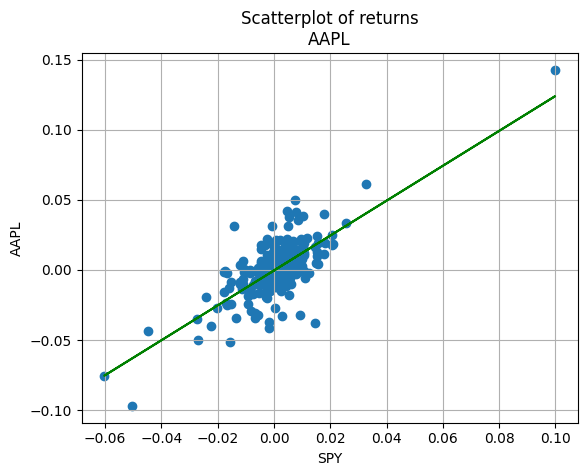

In [18]:
str_title = 'Scatterplot of returns' + '\n' + tickers[0]
plt.figure()
plt.title(str_title)
plt.scatter(returns_benchmark, rets["AAPL"].values)
plt.plot(returns_benchmark, predictor_linreg, color='green')
plt.ylabel(tickers[0])
plt.xlabel(tickers[-1])
plt.grid()
plt.show()

In [20]:
X = sm.add_constant(returns_benchmark)
y = rets["AAPL"].values

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     313.6
Date:                Mon, 09 Feb 2026   Prob (F-statistic):           8.42e-46
Time:                        21:00:38   Log-Likelihood:                 717.02
No. Observations:                 248   AIC:                            -1430.
Df Residuals:                     246   BIC:                            -1423.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.459      0.6

In [22]:
returns_benchmark = rets["SPY"].values
for ticker in tickers[:-1]:  # excluimos SPY
    returns_asset = rets[ticker].values
    slope, intercept, r_value, p_value, std_err = linregress(returns_benchmark, returns_asset)
    print(f"{ticker} - Beta: {slope:.4f}, Alpha diaria: {intercept:.6f}, p-value alpha: {p_value:.4f}, correlation: {r_value:.4f}, R^2: {r_value**2:.4f}")


AAPL - Beta: 1.2445, Alpha diaria: -0.000394, p-value alpha: 0.0000, correlation: 0.7486, R^2: 0.5604
MSFT - Beta: 0.8680, Alpha diaria: 0.000038, p-value alpha: 0.0000, correlation: 0.6981, R^2: 0.4873
GOOGL - Beta: 1.0318, Alpha diaria: 0.001332, p-value alpha: 0.0000, correlation: 0.6185, R^2: 0.3825


## Portafolio de betas maximizando con sharpe ratio

Supongamos que tenemos un portafolio $P$ conformado por $n$ activos. La beta de dicho portafolio estará determinada por

$$\beta_P = \sum_{i=1}^n wi_i * \beta_i$$

donde $\beta_i$ es la beta del activo $i$ en el portafolio y $w_i$ es el peso del activo $i$ dentro del portafolio.

El Sharpe ratio se define como

$$\dfrac{r_p-r_f}{\sigma_p}$$

In [ ]:
# function compute beta

In [ ]:
# function beta portfolio

# 4 Modelos multifactor: cuando una beta no alcanza

## 4.1 Creamos factores “estilo”

Ejemplo típico: mercado + tamaño + valor + momentum (toy model).

In [14]:
np.random.seed(21)

n = 1800
mkt = np.random.normal(0.00035, 0.011, size=n)
smb = np.random.normal(0.00010, 0.006, size=n)   # size
hml = np.random.normal(0.00008, 0.006, size=n)   # value
mom = np.random.normal(0.00012, 0.007, size=n)   # momentum
rf  = np.full(n, 0.00008)

# Activo con exposición a varios factores
b = {"mkt": 1.1, "smb": 0.4, "hml": -0.2, "mom": 0.5}
alpha_true = 0.00001
eps = np.random.normal(0, 0.013, size=n)

asset = alpha_true + b["mkt"]*(mkt-rf) + b["smb"]*smb + b["hml"]*hml + b["mom"]*mom + eps

df2 = pd.DataFrame({
    "RF": rf,
    "MKT_EXCESS": mkt-rf,
    "SMB": smb,
    "HML": hml,
    "MOM": mom,
    "ASSET_EXCESS": asset-rf
})

print(df2.head(3))

        RF  MKT_EXCESS       SMB       HML       MOM  ASSET_EXCESS
0  0.00008   -0.000302  0.000588  0.012697  0.007610     -0.006433
1  0.00008   -0.000953 -0.006698  0.011082  0.002145      0.004347
2  0.00008    0.011730  0.007269  0.000101  0.005323     -0.013015
